# Forecasting Physician Demand

The adapted Physician Density (PD) Prediction Model from Tsai et al. (2012) was used to forecast physician density using available data. Only two variables—the proportion of people under 15 and life expectancy—were employed in this model. Link of paper is here https://bmchealthservres.biomedcentral.com/articles/10.1186/1472-6963-12-79.


Prior to projecting the variables that will be used in the model for the years 2021 through 2030, we preprocessed the dataset we obtained from PSA. We have a total of 8 variables for demand:

- Proportion of pop. under age 15
- Proportion of pop. over age 60
- Aggregate mortality rate
- Maternal mortality rate
- Infant mortality rate
- Life expectancy
- GDP

Note that morbidity data, was excluded from our analysis since some regions have missing information.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-gcrbi2tw because the default path (/home/jjayme/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Compiling all Demand Data

In [2]:
# population data
df_pop = pd.read_csv('~/cpt5/capstone/data/processed/'
                     'regional_projection_2010_2030.csv')

# age specific proportion
df_ageprop = pd.read_csv('~/cpt5/capstone/data/processed/'
                         'age_specific_population.csv')

# mortality data per 100k
df_death = pd.read_csv('~/cpt5/capstone/jjayme/'
                           'mortality_rate_per_100k_2010-2030.csv')

# GDP data
df_gdp = pd.read_csv('~/cpt5/capstone/jjayme/regional_GDP_projected.csv')

# maternal death data
df_maternal = pd.read_csv('~/cpt5/capstone/jjayme/maternal_rate_2010-2030.csv')

# infant death data
df_infant = pd.read_csv('~/cpt5/capstone/jjayme/infant_death_rate_'
                        '2010-2030.csv')

# life expectancy
df_lifeExp = pd.read_csv('~/cpt5/capstone/data/processed/life_expectancy_'
                         'clean_v3.csv')

# Population density

df_density = pd.read_csv('~/cpt5/capstone/data/processed/regional_population'
                         '_density_2010_2030.csv')

In [3]:
# Further cleaning and Preprocessing data

df_death.drop(columns='Unnamed: 0', inplace=True)
df_pop.drop(columns='Unnamed: 0', inplace=True)
df_ageprop.drop(columns='Unnamed: 0', inplace=True)
df_maternal.drop(columns='Unnamed: 0', inplace=True)
df_infant.drop(columns='Unnamed: 0', inplace=True)
df_lifeExp.drop(columns='Unnamed: 0', inplace=True)
df_density.drop(columns='Unnamed: 0', inplace=True)

df_pop.set_index('year', inplace=True)
df_death.set_index('year', inplace=True)

## Preparing Population Data

In [4]:
df_pop.head()

,Philippines,NCR,CAR,I - Ilocos,II - Cagayan,III - C. Luzon,IVA - Calabarzon,MIMAROPA,V - Bicol,VI - W. Visayas,VII - C. Visayas,VIII - E. Visayas,IX - Zamboanga,X - N. Mindanao,XI - Davao,XII - SOCCSKSARGEN,XIII - Caraga,BARMM
year,,,,,,,,,,,,,,,,,,
2010,92337852.0,11855975.0,1616867.0,4748372.0,3229163.0,10137737.0,12609803.0,2744671.0,5420411.0,7102438.0,6800180.0,4101322.0,3407353.0,4297323.0,4468563.0,4109571.0,2429224.0,3256140.0
2011,94036955.8,12056622.2,1637520.4,4802931.8,3272824.0,10350003.4,12965281.6,2787635.0,5494390.2,7187679.6,6917412.8,4167888.0,3451048.4,4374333.2,4552012.0,4195172.4,2462126.8,3359882.8
2012,95736059.6,12257269.4,1658173.8,4857491.6,3316485.0,10562269.8,13320760.2,2830599.0,5568369.4,7272921.2,7034645.6,4234454.0,3494743.8,4451343.4,4635461.0,4280773.8,2495029.6,3463625.6
2013,97435163.4,12457916.6,1678827.2,4912051.4,3360146.0,10774536.2,13676238.8,2873563.0,5642348.6,7358162.8,7151878.4,4301020.0,3538439.2,4528353.6,4718910.0,4366375.2,2527932.4,3567368.4
2014,99134267.2,12658563.8,1699480.6,4966611.2,3403807.0,10986802.6,14031717.4,2916527.0,5716327.8,7443404.4,7269111.2,4367586.0,3582134.6,4605363.8,4802359.0,4451976.6,2560835.2,3671111.2


In [5]:
# rename columns
columns = ['PHILIPPINES',
           "NCR", "CAR", "I - Ilocos", "II - Cagayan",
          "III - C. Luzon", "IVA - Calabarzon",
          "MIMAROPA", "V - Bicol", "VI - W. Visayas",
          "VII - C. Visayas", "VIII - E. Visayas", 
          "IX - Zamboanga",
          "X - N. Mindanao", "XI - Davao", "XII - SOCCSKSARGEN",
          "XIII - Caraga", "BARMM"]
region_list = ["NCR", "CAR", "I - Ilocos", "II - Cagayan",
          "III - C. Luzon", "IVA - Calabarzon",
          "MIMAROPA", "V - Bicol", "VI - W. Visayas",
          "VII - C. Visayas", "VIII - E. Visayas", 
          "IX - Zamboanga",
          "X - N. Mindanao", "XI - Davao", "XII - SOCCSKSARGEN",
          "XIII - Caraga", "BARMM"]

df_pop.columns = columns

In [6]:
# transform data
df_pop = df_pop.reset_index()
df_population = pd.melt(df_pop, id_vars='year', value_vars=region_list)
df_population.rename(columns={'variable':'Region', 'value':'population'}
                   ,inplace=True)
df_population['population'] = df_population['population'].astype(int)
df_population.tail()

,year,Region,population
352,2026,BARMM,5293197
353,2027,BARMM,5363601
354,2028,BARMM,5434584
355,2029,BARMM,5506197
356,2030,BARMM,5578399


## Preparing Mortality rate Data 

In [7]:
# rename columns
region_list = ["NCR", "CAR", "I - Ilocos", "II - Cagayan",
          "III - C. Luzon", "IVA - Calabarzon",
          "MIMAROPA", "V - Bicol", "VI - W. Visayas",
          "VII - C. Visayas", "VIII - E. Visayas", 
          "IX - Zamboanga",
          "X - N. Mindanao", "XI - Davao", "XII - SOCCSKSARGEN",
          "XIII - Caraga", "BARMM"]

df_death.columns = columns

In [8]:
df_death.head(2)

,PHILIPPINES,NCR,CAR,I - Ilocos,II - Cagayan,III - C. Luzon,IVA - Calabarzon,MIMAROPA,V - Bicol,VI - W. Visayas,VII - C. Visayas,VIII - E. Visayas,IX - Zamboanga,X - N. Mindanao,XI - Davao,XII - SOCCSKSARGEN,XIII - Caraga,BARMM
year,,,,,,,,,,,,,,,,,,
2010,528.500490,578.265389,398.301159,691.078963,556.769664,563.873377,549.350374,456.521018,579.291866,652.930726,607.130988,493.109295,389.481219,463.311694,530.618009,369.795290,437.300142,38.419724
2011,529.870407,568.069554,411.597926,675.399971,556.186339,561.767931,541.484575,471.869524,599.666183,645.729952,589.627960,517.648267,420.654778,480.713266,539.036365,383.393064,470.325086,42.590771


In [9]:
# transform data
df_death.reset_index(inplace=True)
df_mortality = pd.melt(df_death, id_vars='year', value_vars=region_list)
df_mortality.rename(columns={'variable':'Region', 'value':'mortality_rate_100k'}
                   ,inplace=True)
df_mortality.tail()

,year,Region,mortality_rate_100k
352,2026,BARMM,66.0
353,2027,BARMM,66.0
354,2028,BARMM,66.0
355,2029,BARMM,66.0
356,2030,BARMM,66.0


## Preparing GDP data

In [10]:
df_gdp.drop(columns=['Unnamed: 0', 'GDP_log'], inplace=True)

In [11]:
# renaming Region
df_gdp['Region'].replace({
                 'NATIONAL CAPITAL REGION (NCR)': "NCR", 
                 'CORDILLERA ADMINISTRATIVE REGION (CAR)': 'CAR',
                 'REGION I (ILOCOS REGION)': "I - Ilocos",
                 'REGION II (CAGAYAN VALLEY)': "II - Cagayan",
                 'REGION III (CENTRAL LUZON)': "III - C. Luzon",
                 'REGION IV-A (CALABARZON)': "IVA - Calabarzon",
                 'MIMAROPA REGION': "MIMAROPA",
                 'REGION V (BICOL REGION)': "V - Bicol",
                 'REGION VI (WESTERN VISAYAS)': "VI - W. Visayas",
                 'REGION VII (CENTRAL VISAYAS)': "VII - C. Visayas" ,
                 'REGION VIII (EASTERN VISAYAS)': "VIII - E. Visayas",
                 'REGION IX (ZAMBOANGA PENINSULA)': "IX - Zamboanga",
                 'REGION X (NORTHERN MINDANAO)': "X - N. Mindanao",
                 'REGION XI (DAVAO REGION)':"XI - Davao",
                 'REGION XII (SOCCSKSARGEN)':"XII - SOCCSKSARGEN",
                 'REGION XIII (Caraga)': "XIII - Caraga",
                 'BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANAO (BARMM)':
                                                            "BARMM"

                        }, inplace=True)


In [12]:
df_gdp.head()

,Region,Year,Gross Regional Domestic Product
0,NCR,2010,3.053160e+09
1,CAR,2010,1.897668e+08
2,I - Ilocos,2010,3.126284e+08
3,II - Cagayan,2010,1.928803e+08
4,III - C. Luzon,2010,9.792877e+08


In [13]:
# rename columns
df_gdp.columns = ['Region', 'year', 'rGDP']

In [14]:
df_gdp

,Region,year,rGDP
0,NCR,2010,3.053160e+09
1,CAR,2010,1.897668e+08
2,I - Ilocos,2010,3.126284e+08
3,II - Cagayan,2010,1.928803e+08
4,III - C. Luzon,2010,9.792877e+08
...,...,...,...
352,X - N. Mindanao,2030,1.573680e+09
353,XI - Davao,2030,1.624737e+09
354,XII - SOCCSKSARGEN,2030,8.547046e+08
355,XIII - Caraga,2030,5.327731e+08


## Prepare Age-Specific Proportion Data

In [15]:
df_ageprop.head()

,year,Region,under15_population,total_population,over60_population,proportion_under15,proportion_over60
0,2010,BARMM,1386400.0,3264100.0,94000.0,0.424742,0.028798
1,2011,BARMM,1426772.0,3366250.8,97590.8,0.423846,0.028991
2,2012,BARMM,1467144.0,3468401.6,101181.6,0.423003,0.029172
3,2013,BARMM,1507516.0,3570552.4,104772.4,0.422208,0.029343
4,2014,BARMM,1547888.0,3672703.2,108363.2,0.421457,0.029505


## Prepare population density

In [16]:
df_density.tail()

,year,Region,population_density
352,2026,BARMM,143.0
353,2027,BARMM,145.0
354,2028,BARMM,147.0
355,2029,BARMM,149.0
356,2030,BARMM,151.0


## Prepare Life Expectancy Data

In [17]:
df_lifeExp.head()

,year,NCR,CAR,I - Ilocos,II - Cagayan,III - C. Luzon,IVA - Calabarzon,MIMAROPA,V - Bicol,VI - W. Visayas,VII - C. Visayas,VIII - E. Visayas,IX - Zamboanga,X - N. Mindanao,XI - Davao,XII - SOCCSKSARGEN,XIII - Caraga,BARMM
0,2010,71.019294,68.492383,71.515762,69.240025,70.829473,70.700775,69.166488,68.554212,69.688459,70.017242,67.372968,67.342479,67.940863,67.710243,68.324052,66.539906,59.936557
1,2011,71.259294,68.792383,71.755762,69.540025,71.069473,70.970814,69.466488,68.854212,69.958938,70.287615,67.724395,67.693422,68.240863,68.058966,68.624052,66.939906,60.436557
2,2012,71.499294,69.092383,71.995762,69.840025,71.309473,71.240852,69.766488,69.154212,70.229416,70.557987,68.075821,68.044365,68.540863,68.407690,68.924052,67.339906,60.936557
3,2013,71.739294,69.392383,72.235762,70.140025,71.549473,71.510890,70.066488,69.454212,70.499895,70.828359,68.427248,68.395308,68.840863,68.756414,69.224052,67.739906,61.436557
4,2014,71.979294,69.692383,72.475762,70.440025,71.789473,71.780928,70.366488,69.754212,70.770374,71.098731,68.778674,68.746251,69.140863,69.105137,69.524052,68.139906,61.936557


In [18]:
# Transform dataset
df_lifeExp = pd.melt(df_lifeExp, id_vars='year', value_vars=region_list)
df_lifeExp.columns = ['year', 'Region', 'life_expectancy']
df_lifeExp

,year,Region,life_expectancy
0,2010,NCR,71.019294
1,2011,NCR,71.259294
2,2012,NCR,71.499294
3,2013,NCR,71.739294
4,2014,NCR,71.979294
...,...,...,...
352,2026,BARMM,67.337501
353,2027,BARMM,67.687658
354,2028,BARMM,68.037815
355,2029,BARMM,68.387973


## Prepare Infant Mortality rate Data

In [19]:
df_infant.head()

,year,Region,infant_death_rate_per100k
0,2010,NCR,1841.755959
1,2010,CAR,818.374601
2,2010,I - Ilocos,1497.749812
3,2010,II - Cagayan,919.216215
4,2010,III - C. Luzon,1064.173005


## Prepare Maternal Mortality rate Data

In [20]:
df_maternal.head()

,year,Region,maternal_death_rate_per100k
0,2010,BARMM,13.211785
1,2011,BARMM,51.981806
2,2012,BARMM,67.254521
3,2013,BARMM,38.449708
4,2014,BARMM,67.645268


# Merge Datasets

In [21]:
df = df_population.merge(df_mortality, on=['year', 'Region'], how='left')
df = df.merge(df_gdp, on=['year', 'Region'])
df = df.merge(df_ageprop[['year', 'Region', 'proportion_under15',
                     'proportion_over60']], on=['year', 'Region'], how='left')
df = df.merge(df_lifeExp, on=['year', 'Region'])
df = df.merge(df_infant, on=['year', 'Region'])
df = df.merge(df_maternal, on=['year', 'Region'])
df = df.merge(df_density, on=['year', 'Region'])
df.head()

,year,Region,population,mortality_rate_100k,rGDP,proportion_under15,proportion_over60,life_expectancy,infant_death_rate_per100k,maternal_death_rate_per100k,population_density
0,2010,NCR,11855975,578.265389,3.053160e+09,0.289812,0.057599,71.019294,1841.755959,88.105727,19136.0
1,2011,NCR,12056622,568.069554,3.237139e+09,0.285974,0.059408,71.259294,1821.869754,66.257200,19460.0
2,2012,NCR,12257269,571.236527,3.553089e+09,0.282257,0.061161,71.499294,1838.911067,61.944825,19784.0
3,2013,NCR,12457916,570.320081,3.890702e+09,0.278655,0.062858,71.739294,1818.360930,89.481418,20108.0
4,2014,NCR,12658563,570.641355,4.215201e+09,0.275163,0.064504,71.979294,1787.799913,88.013481,20432.0


In [22]:
df['proportion_under15'] = df['proportion_under15']*100
df['proportion_over60'] = df['proportion_over60']*100

In [23]:
df.columns

Index(['year', 'Region', 'population', 'mortality_rate_100k', 'rGDP',
       'proportion_under15', 'proportion_over60', 'life_expectancy',
       'infant_death_rate_per100k', 'maternal_death_rate_per100k',
       'population_density'],
      dtype='object')

In [24]:
## WHO recommended PD
df['WHO_PD'] = 10

In [25]:
df.isna().sum()

year                           0
Region                         0
population                     0
mortality_rate_100k            0
rGDP                           0
proportion_under15             0
proportion_over60              0
life_expectancy                0
infant_death_rate_per100k      0
maternal_death_rate_per100k    0
population_density             0
WHO_PD                         0
dtype: int64

In [26]:
data = df[['mortality_rate_100k', 'rGDP', 'population_density',
            'proportion_under15', 'proportion_over60',
           'infant_death_rate_per100k',
           'maternal_death_rate_per100k', 'life_expectancy',
           'WHO_PD']]

In [27]:
df.to_csv('~/cpt5/capstone/data/processed/dataset_demand_compiled_v1.csv')

# Correlation between pairs of features

Below is the correlation between every pair of feature (independent variables) and the other variable `demand_doctors`, and visualization of the Pearson correlations using a heatmap.

In [28]:
import seaborn as sns

### Show correlation plot of all variables

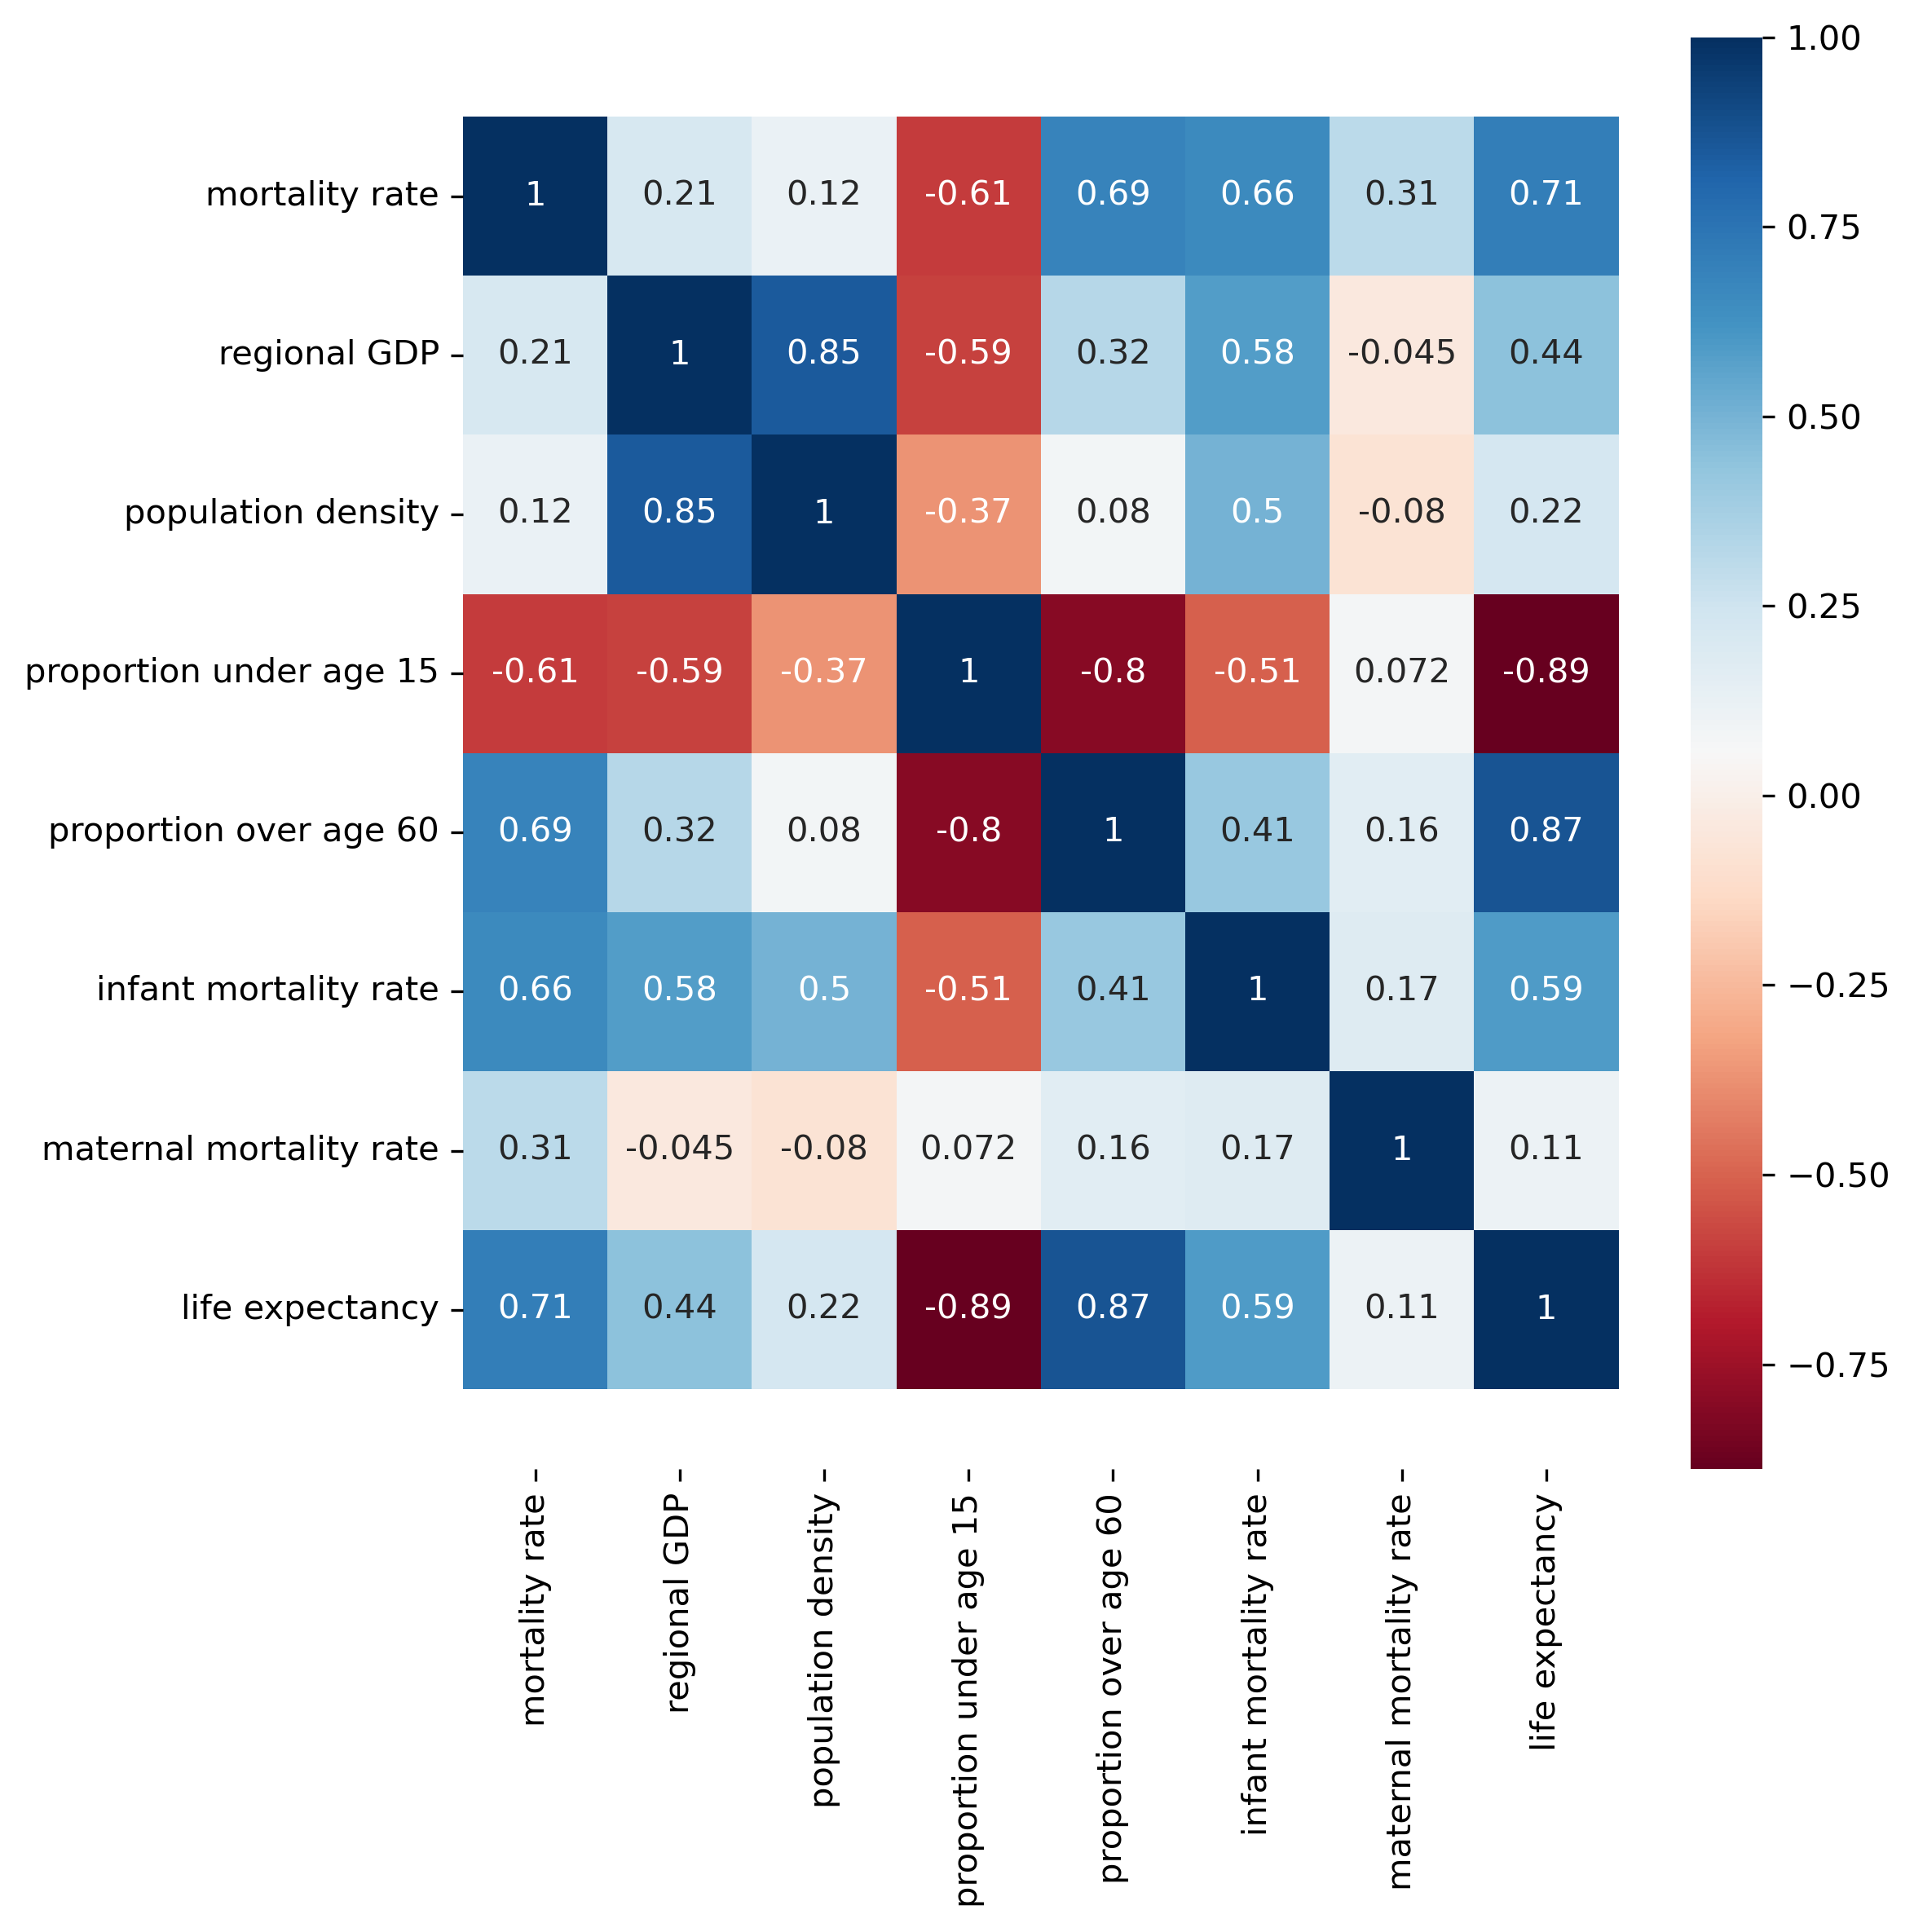

In [29]:
# Show correlation plot of all variables
dx = df[['mortality_rate_100k', 'rGDP', 'population_density',
            'proportion_under15', 'proportion_over60',
           'infant_death_rate_per100k',
           'maternal_death_rate_per100k', 'life_expectancy']]

dx.columns = ['mortality rate', 'regional GDP', 'population density',
            'proportion under age 15', 'proportion over age 60',
           'infant mortality rate','maternal mortality rate',
            'life expectancy']

plt.figure(figsize=(8,8), dpi=300)
sns.heatmap(data=dx.corr(method='pearson'), annot=True, fmt=".2g", cmap='RdBu')

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() #
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.tight_layout()
plt.savefig('correlation_plot.png', dpi=300)

In [30]:
# p-values of the Pearson R correlation
from scipy.stats import pearsonr
pval_df = dx.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(dx.columns))

In [31]:
pval_df

,mortality rate,regional GDP,population density,proportion under age 15,proportion over age 60,infant mortality rate,maternal mortality rate,life expectancy
mortality rate,0.000000e+00,4.382799e-05,2.700783e-02,5.036908e-37,6.300712e-51,9.444957e-46,1.669467e-09,1.740374e-56
regional GDP,4.382799e-05,0.000000e+00,6.946043e-102,7.804109e-35,3.318249e-10,1.311147e-33,3.931768e-01,1.076505e-18
population density,2.700783e-02,6.946043e-102,0.000000e+00,4.452777e-13,1.316066e-01,5.720081e-24,1.311561e-01,2.682987e-05
proportion under age 15,5.036908e-37,7.804109e-35,4.452777e-13,0.000000e+00,1.007493e-81,3.657203e-25,1.717683e-01,7.845193e-122
proportion over age 60,6.300712e-51,3.318249e-10,1.316066e-01,1.007493e-81,0.000000e+00,4.083561e-16,1.958068e-03,3.245550e-113
infant mortality rate,9.444957e-46,1.311147e-33,5.720081e-24,3.657203e-25,4.083561e-16,0.000000e+00,9.377453e-04,1.481633e-34
maternal mortality rate,1.669467e-09,3.931768e-01,1.311561e-01,1.717683e-01,1.958068e-03,9.377453e-04,0.000000e+00,4.039884e-02
life expectancy,1.740374e-56,1.076505e-18,2.682987e-05,7.845193e-122,3.245550e-113,1.481633e-34,4.039884e-02,0.000000e+00


## Removing BARMM to see if there are changes with correlation plots

In [32]:
df_removeBarmm = df[~(df['Region'] == 'BARMM')]
df_removeBarmm.tail()

,year,Region,population,mortality_rate_100k,rGDP,proportion_under15,proportion_over60,life_expectancy,infant_death_rate_per100k,maternal_death_rate_per100k,population_density,WHO_PD
331,2026,XIII - Caraga,2975365,530.0,4.141369e+08,31.482522,9.315221,71.634117,874.827397,133.876048,140.0,10
332,2027,XIII - Caraga,3002596,530.0,4.410558e+08,31.079098,9.504467,71.874117,874.827397,133.876048,142.0,10
333,2028,XIII - Caraga,3030102,530.0,4.697244e+08,30.710165,9.677532,72.114117,874.827397,133.876048,143.0,10
334,2029,XIII - Caraga,3057890,530.0,5.002565e+08,30.371482,9.836407,72.354117,874.827397,133.876048,144.0,10
335,2030,XIII - Caraga,3085948,530.0,5.327731e+08,30.059474,9.982769,72.594117,874.827397,133.876048,146.0,10


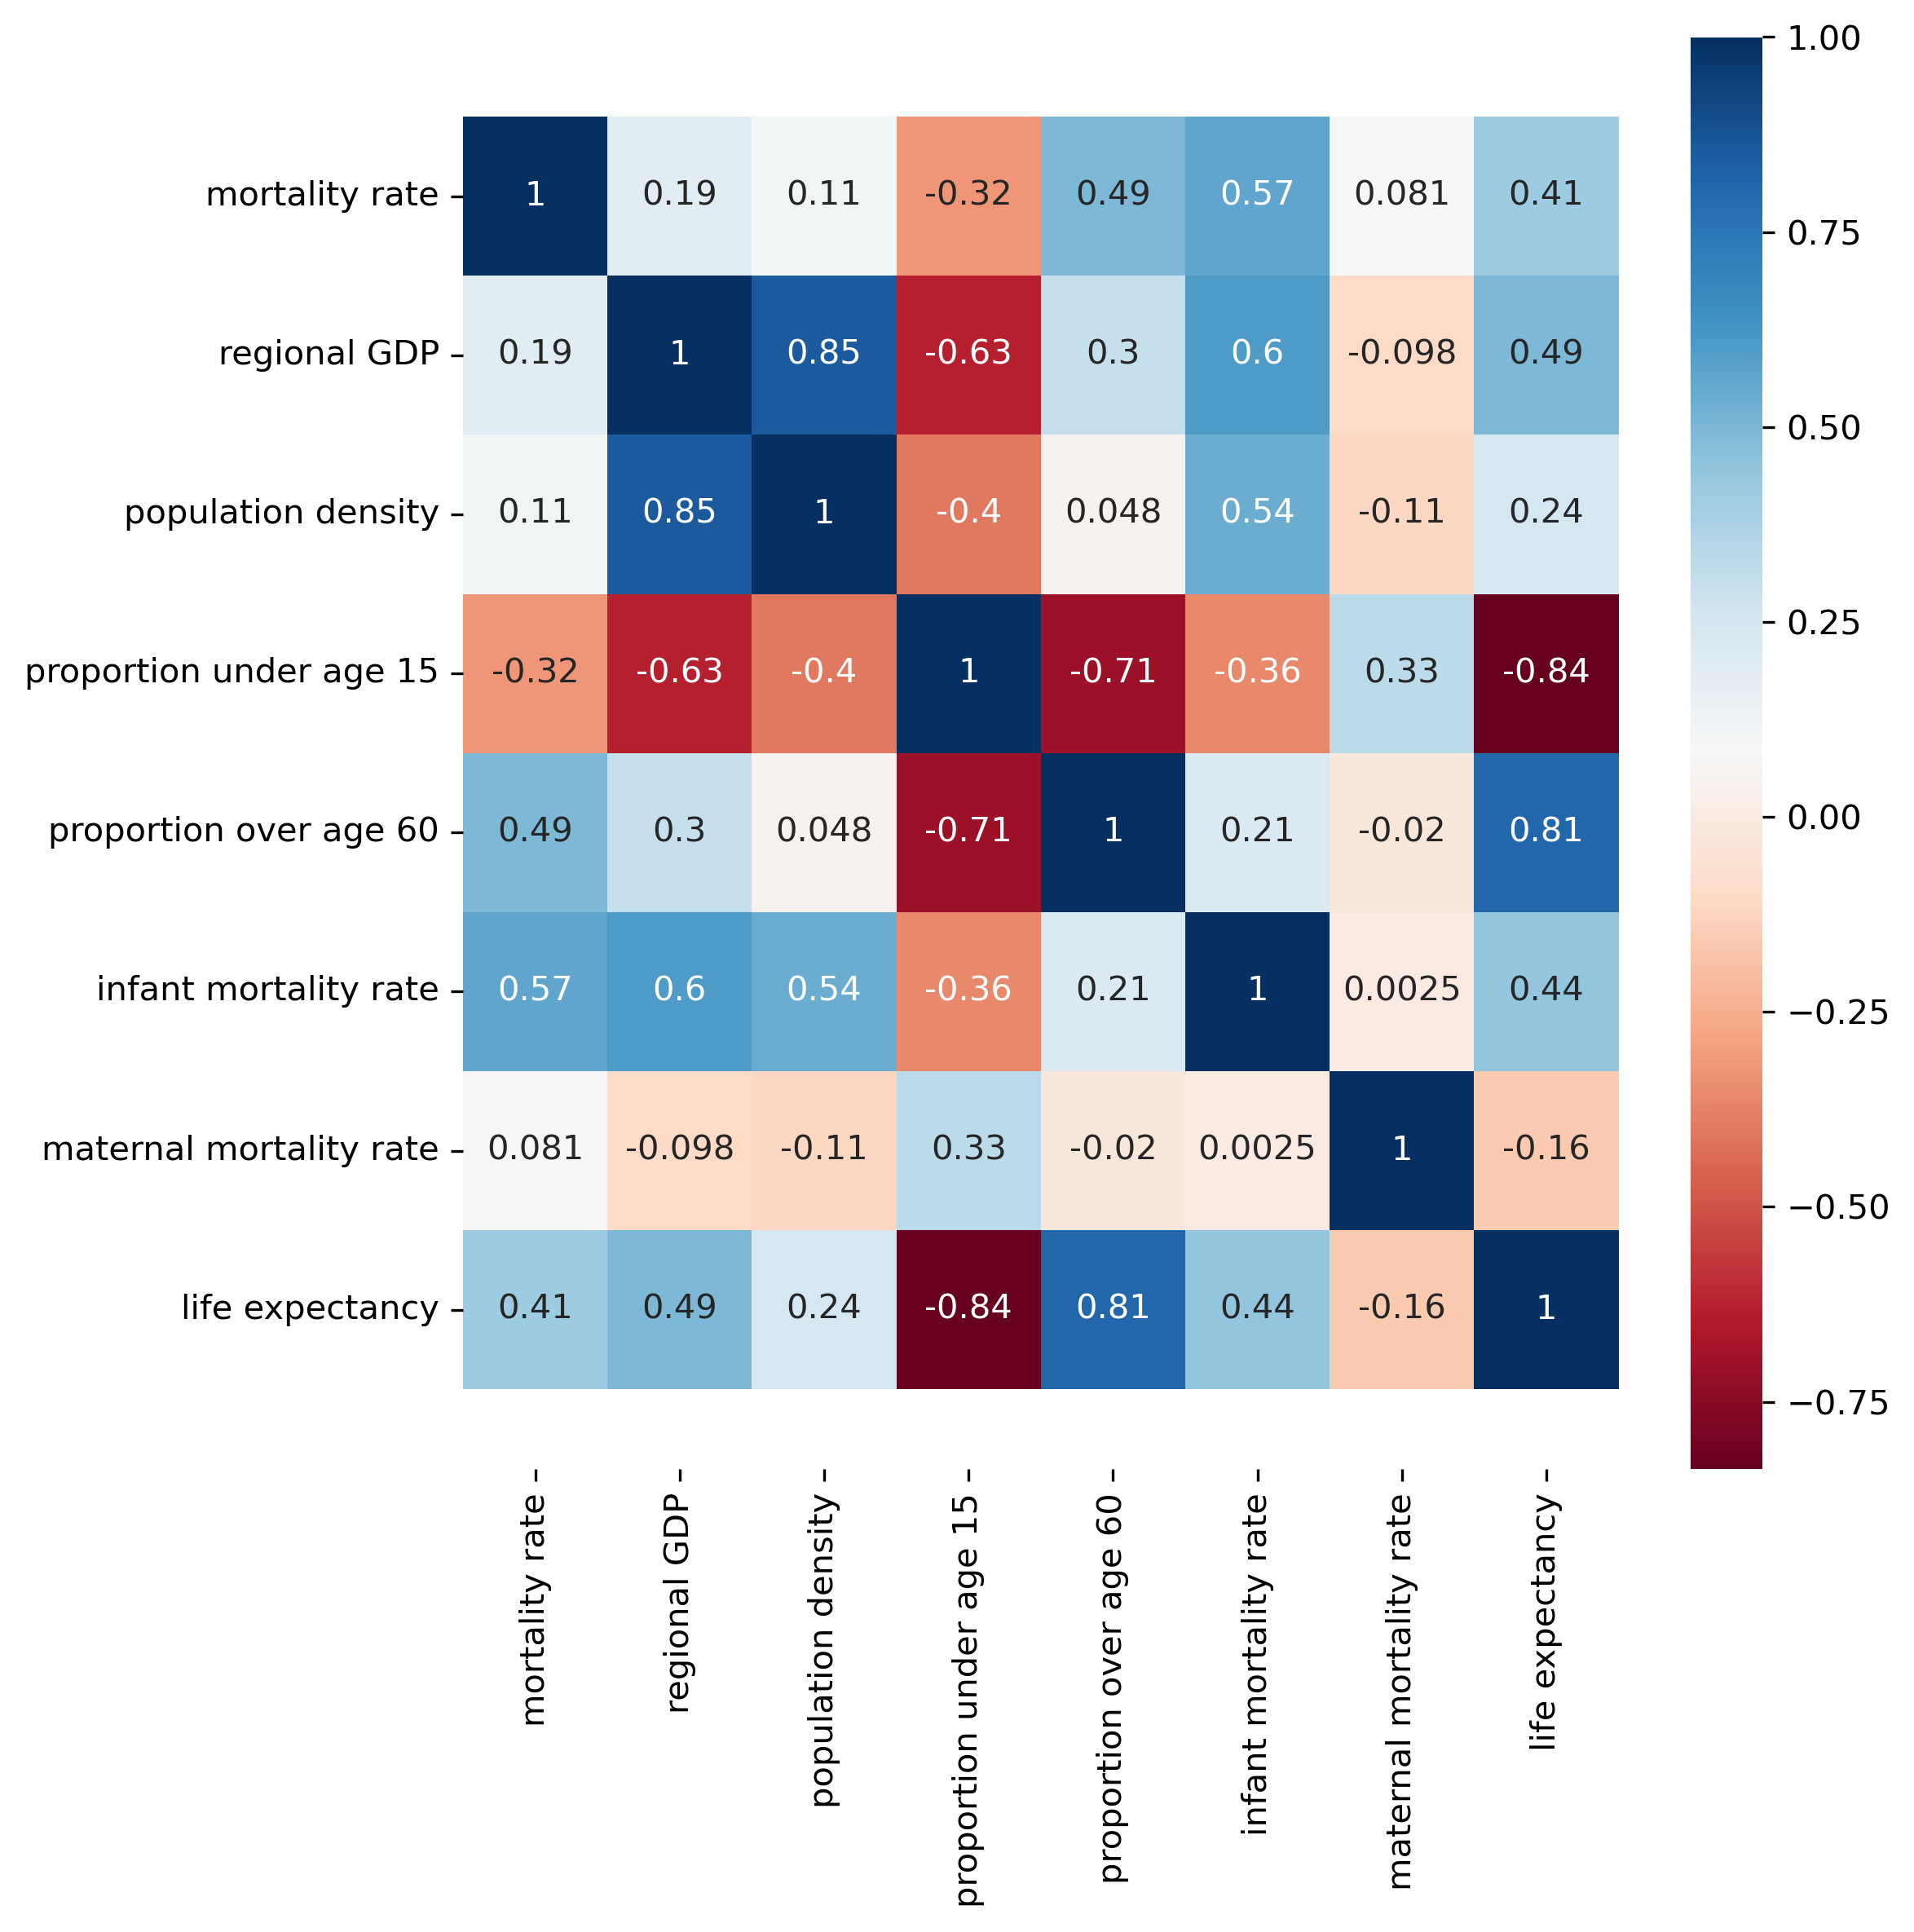

In [33]:
# Show correlation plot of all variables
dx = df_removeBarmm[['mortality_rate_100k', 'rGDP', 'population_density',
            'proportion_under15', 'proportion_over60',
           'infant_death_rate_per100k',
           'maternal_death_rate_per100k', 'life_expectancy']]

dx.columns = ['mortality rate', 'regional GDP', 'population density',
            'proportion under age 15', 'proportion over age 60',
           'infant mortality rate','maternal mortality rate',
            'life expectancy']

plt.figure(figsize=(8,8), dpi=300)
sns.heatmap(data=dx.corr(method='pearson'), annot=True, fmt=".2g", cmap='RdBu')

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() #
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.tight_layout()
plt.savefig('correlation_plot_BARMM_removed.png', dpi=300)

In [34]:
dx.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(dx.columns))

,mortality rate,regional GDP,population density,proportion under age 15,proportion over age 60,infant mortality rate,maternal mortality rate,life expectancy
mortality rate,0.000000e+00,4.955747e-04,4.990358e-02,1.606702e-09,3.682390e-22,5.266382e-30,1.389243e-01,3.054507e-15
regional GDP,4.955747e-04,0.000000e+00,3.576283e-96,1.719707e-38,1.386736e-08,2.099974e-34,7.361659e-02,4.020676e-22
population density,4.990358e-02,3.576283e-96,0.000000e+00,1.232169e-14,3.777357e-01,1.023764e-26,4.024762e-02,7.221637e-06
proportion under age 15,1.606702e-09,1.719707e-38,1.232169e-14,0.000000e+00,5.547358e-52,1.763240e-11,7.763174e-10,4.201732e-89
proportion over age 60,3.682390e-22,1.386736e-08,3.777357e-01,5.547358e-52,0.000000e+00,9.062582e-05,7.204843e-01,9.511766e-80
infant mortality rate,5.266382e-30,2.099974e-34,1.023764e-26,1.763240e-11,9.062582e-05,0.000000e+00,9.640158e-01,9.926949e-18
maternal mortality rate,1.389243e-01,7.361659e-02,4.024762e-02,7.763174e-10,7.204843e-01,9.640158e-01,0.000000e+00,3.066905e-03
life expectancy,3.054507e-15,4.020676e-22,7.221637e-06,4.201732e-89,9.511766e-80,9.926949e-18,3.066905e-03,0.000000e+00


Text(0, 0.5, 'Mortality Rate')

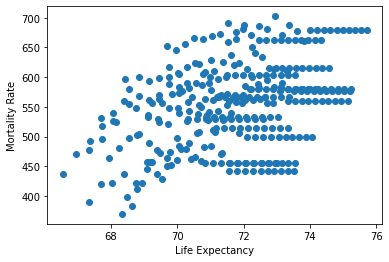

In [35]:
plt.scatter(df_removeBarmm['life_expectancy'], df_removeBarmm['mortality_rate_100k'] )
plt.xlabel('Life Expectancy')
plt.ylabel('Mortality Rate')

# Predict PD using PD Prediction Model

In [36]:
df['PD'] = (5.014 - 0.128*df['proportion_under15'] + 0.034*df['life_expectancy'])**2

In [37]:
df.sample(5)

,year,Region,population,mortality_rate_100k,rGDP,proportion_under15,proportion_over60,life_expectancy,infant_death_rate_per100k,maternal_death_rate_per100k,population_density,WHO_PD,PD
74,2021,II - Cagayan,3729141,580.000000,3.789162e+08,29.322158,9.912623,72.180025,1004.137915,67.870426,124.0,10,13.800368
66,2013,II - Cagayan,3360146,576.582089,2.683045e+08,31.112447,7.844323,70.140025,1035.837787,77.019805,112.0,10,11.671568
238,2017,IX - Zamboanga,3693191,463.637001,3.446676e+08,33.872578,7.405899,69.697194,816.305836,86.193784,218.0,10,9.290393
177,2019,VI - W. Visayas,7835883,687.848453,9.191631e+08,29.550480,10.204121,72.000853,1534.385694,94.442605,613.0,10,13.539218
36,2025,CAR,1898676,455.000000,3.954495e+08,28.364370,9.046136,72.545322,883.660119,58.070590,95.0,10,14.821742


# Plot PD for visualization

In [38]:
labels = ["NCR", "CAR", "I - Ilocos", "II - Cagayan",
          "III - C. Luzon", "IVA - Calabarzon",
          "MIMAROPA", "V - Bicol", "VI - W. Visayas",
          "VII - C. Visayas", "VIII - E. Visayas", 
          "IX - Zamboanga",
          "X - N. Mindanao", "XI - Davao", "XII - SOCCSKSARGEN",
          "XIII - Caraga", "BARMM"]

In [39]:
df_x = df[df['year'] > 2021][['year', 'Region', 'WHO_PD', 'PD']]

In [40]:
df_x

,year,Region,WHO_PD,PD
12,2022,NCR,10,17.416605
13,2023,NCR,10,17.632299
14,2024,NCR,10,17.850039
15,2025,NCR,10,18.068942
16,2026,NCR,10,18.770631
...,...,...,...,...
352,2026,BARMM,10,6.850954
353,2027,BARMM,10,7.187704
354,2028,BARMM,10,7.518603
355,2029,BARMM,10,7.843745


In [41]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
         'tab:brown', 'tab:pink', 'indigo', 'tab:olive', 'tab:cyan',
         'darkmagenta', 'maroon', 'lime', 'darkolivegreen', 'cadetblue',
         'darkgoldenrod', 'fuchsia']

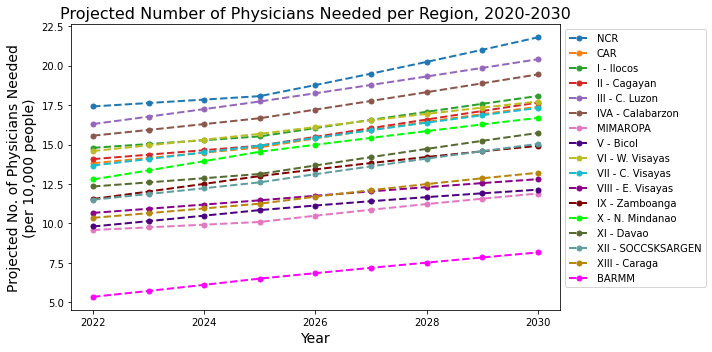

In [42]:
plt.figure(figsize=(10,5))
for i,j in enumerate(labels):
    df_y = df_x[df_x['Region'] == j]
    plt.plot(df_y['year'], df_y['PD'],ls='--', marker='.',markersize=10,
             label=j, lw=2, color=colors[i])
        
plt.legend(bbox_to_anchor=(1,1))
    
plt.xticks(np.arange(2022,2031,2))
plt.title('Projected Number of Physicians Needed per Region, 2020-2030',
          fontsize=16)

plt.ylabel('Projected No. of Physicians Needed\n(per 10,000 people)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.tight_layout()
plt.savefig('PD_Cb.png', dpi=300);

# Bivariate analysis

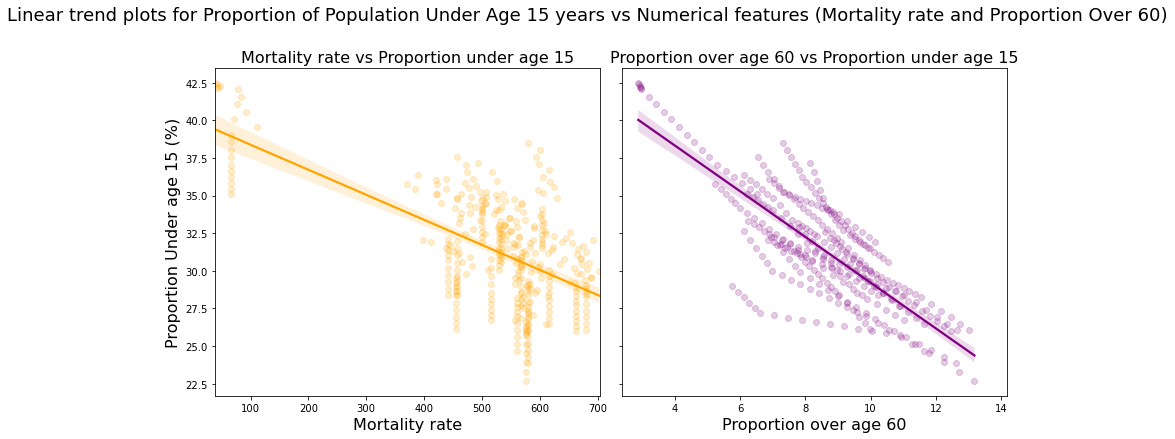

In [43]:
#create three sets of axes using subplots
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12,6))

#create a custom plot for each set of axes
for item, i, color,xlabel, in list(zip(['mortality_rate_100k',
                                'proportion_over60'], list(range(2)),
                                ['orange', 'purple', ],
                                ['Mortality rate','Proportion over age 60'])):
    
    sns.regplot(ax=axes[i], data=df, x=df[item], y=df['proportion_under15'], 
                scatter_kws={'alpha':0.2}, color=color)
    axes[i].set_title(xlabel + ' vs Proportion under age 15', fontsize=16)
    axes[i].set_xlabel(xlabel, fontsize=16)
    axes[i].set_xlim(df[item].min() - .5, df[item].max() + 1)

#make it so the 'charges' y-axis label is only on the left-most set of axes
for ax in axes.flat:
    ax.label_outer()
    
axes[0].set_ylabel('Proportion Under age 15 (%)', fontsize=16)
plt.suptitle('Linear trend plots for Proportion of Population Under Age 15 years vs Numerical features '
             '(Mortality rate and Proportion Over 60)',
             fontsize=18, y=1.01)
plt.tight_layout()
plt.savefig('correlation_variables.png', dpi=300)

# Curve Fitting

In [44]:
from scipy.optimize import curve_fit

#objective function
def linear(x, m, b):
    return m * x + b


def quadratic(x, m, b):
    return (m * x + b)**2


x=df['proportion_under15'].values
y=df['PD'].values

# fit curve
popt, _ = curve_fit(linear, x, y)

# calculate sum of squared residuals (SSR)
ssr = sum((y - linear(x, popt[0], popt[1]))**2)

# print (i.e. display) the calculated optimal values and the SSR
print('m =', popt[0])
print('b =', popt[1])
print('SSR:', ssr)

m = -0.973022636433115
b = 42.53101110831973
SSR: 63.77964494427549


In [45]:
# fit curve
popt, _ = curve_fit(quadratic, x, y)

# calculate sum of squared residuals (SSR)
ssr = sum((y - quadratic(x, popt[0], popt[1]))**2)

# print (i.e. display) the calculated optimal values and the SSR
print('m =', popt[0])
print('b =', popt[1])
print('SSR:', ssr)

m = -0.14698075399325808
b = 8.03370124292558
SSR: 21.175862468581652


In [46]:
x2=df['life_expectancy'].values
y2=df['PD'].values

popt, pcov = curve_fit(quadratic, x2, y2)

In [47]:
# calculate sum of squared residuals (SSR)
ssr = sum((y2 - quadratic(x2, *popt))**2)

# print (i.e. display) the calculated optimal values and the SSR
print('m =', popt[0])
print('b =', popt[1])
print('SSR:', ssr)

m = 0.21045674591849317
b = -11.57185970827269
SSR: 783.3722326246901


In [48]:
popt, pcov = curve_fit(linear, x2, y2)

# calculate sum of squared residuals (SSR)
ssr = sum((y2 - linear(x2, *popt))**2)

# print (i.e. display) the calculated optimal values and the SSR
print('m =', popt[0])
print('b =', popt[1])
print('SSR:', ssr)

m = 1.2524345774047358
b = -77.20862853279604
SSR: 961.4362251879772


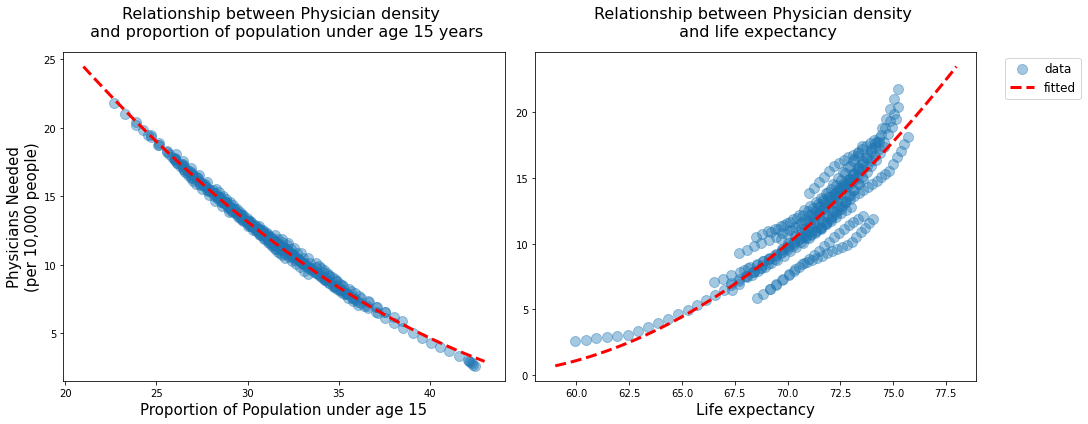

In [49]:
fig, (ax1, ax2) =plt.subplots(1,2, figsize=(15,6))

#plot1
x1 = np.linspace(21,43,100)
y1 = (-0.147 * x1 + 8.034)**2
ax1.scatter(x=df['proportion_under15'], y=df['PD'], alpha=0.4, s=100, label='data')
ax1.plot(x1, y1, 'r--', label='fitted', lw=3)



#plot2
x2 = np.linspace(59, 78,100)
y2 = (-11.572 + 0.21046*x2)**2
ax2.scatter(x=df['life_expectancy'], y=df['PD'], alpha=0.4, s=100, label='data')
ax2.plot(x2, y2, 'r--', label='fitted', lw=3)



ax1.set_ylabel('Physicians Needed\n(per 10,000 people)', fontsize=15)
ax1.set_xlabel('Proportion of Population under age 15', fontsize=15)
ax2.set_xlabel('Life expectancy', fontsize=15)

ax1.set_title('Relationship between Physician density \n'
          ' and proportion of population under age 15 years', y=1.03, fontsize=16)
ax2.set_title('Relationship between Physician density \n'
          ' and life expectancy', y=1.03, fontsize=16)

plt.legend(bbox_to_anchor=(1.25,1), fontsize=12)
plt.tight_layout()
plt.savefig('PD_plots.png', dpi=300);

In [50]:
df.to_csv('~/cpt5/capstone/data/processed/2010-30_demand_forecast.csv')